### Time series machine learning model - ERCOT DayAhead market price forecasting
- Develop a predictive machine learning model for time series data, focusing on forecasting power prices in the ERCOT Day-Ahead market. Utilize traditional machine learning approaches, specifically employing LightGBM, to enhance the accuracy and reliability of the price predictions.

#### Data
- Day Ahead (DA) market
  - Delivery Date
  - Hour Ending
  - Repeated Hour Flag
  - Settlement Point
  - Settle Point Price
- Frequency Regulation (FR) market
  - Delivery Date
  - Hour Ending
  - Repeated Hour Flag
  - REGDN: Regulation downward service price
  - REGUP: Regulation upward service price
  - RRS: Responsive reserve price
  - NSPIN: Non-spinning responsive reserve price
  - ECRS: ERCOT Contingency Reserve Service price

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from astral.sun import sun
from astral import LocationInfo

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from sklearn.feature_selection import RFECV
from skforecast.feature_selection import select_features

from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive

from feature_engine.datetime import DatetimeFeatures
from skforecast.preprocessing import RollingFeatures

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple dependent series forecasting (Direct)
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster

In [125]:
#!pip install astral

In [2]:
# Read files
DAM = pd.read_excel(r'ERCOT_DAM_2024.xlsx', sheet_name=None)
FR = pd.read_csv(r'ERCOT_FR_2024.csv')

In [5]:
DAM = pd.concat(DAM.values(), ignore_index=True)

In [6]:
DAM

,Delivery Date,Hour Ending,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,01/01/2024,01:00,N,HB_BUSAVG,16.28
1,01/01/2024,01:00,N,HB_HOUSTON,15.84
2,01/01/2024,01:00,N,HB_HUBAVG,16.62
3,01/01/2024,01:00,N,HB_NORTH,16.31
4,01/01/2024,01:00,N,HB_PAN,16.97
...,...,...,...,...,...
131755,12/31/2024,24:00,N,LZ_LCRA,20.49
131756,12/31/2024,24:00,N,LZ_NORTH,20.39
131757,12/31/2024,24:00,N,LZ_RAYBN,20.40
131758,12/31/2024,24:00,N,LZ_SOUTH,19.83


In [32]:
FR

,Delivery Date,Hour Ending,Repeated Hour Flag,REGDN,REGUP,RRS,NSPIN,ECRS
0,01/01/2024,01:00,N,1.51,1.49,1.00,0.94,0.10
1,01/01/2024,02:00,N,1.25,1.47,1.00,0.94,0.11
2,01/01/2024,03:00,N,1.25,1.80,1.00,1.23,0.12
3,01/01/2024,04:00,N,1.25,1.60,1.00,1.23,0.13
4,01/01/2024,05:00,N,1.25,2.00,1.01,1.23,0.14
...,...,...,...,...,...,...,...,...
8779,12/31/2024,20:00,N,2.13,1.96,1.50,1.97,1.50
8780,12/31/2024,21:00,N,1.53,1.25,0.50,3.00,0.50
8781,12/31/2024,22:00,N,1.53,0.86,0.50,1.48,0.50
8782,12/31/2024,23:00,N,1.53,0.64,0.48,0.48,0.48


In [8]:
DAM1 = DAM.copy()


# Function to subtract one hour from the time string
def subtract_one_hour(time_str):
    if time_str == "24:00":
        # Treat "24:00" as "00:00" of the next day and subtract one hour
        return "23:00"
    else:
        # Convert string to datetime object
        time_obj = datetime.strptime(time_str, "%H:%M")
        # Subtract one hour using timedelta
        new_time_obj = time_obj - timedelta(hours=1)
        # Convert back to string in "HH:MM" format
        return new_time_obj.strftime("%H:%M")


DAM1['adjusted_time'] = DAM1['Hour Ending'].apply(subtract_one_hour)

In [9]:
DAM1['Datetime'] = DAM1['Delivery Date'] + ' ' + DAM1['adjusted_time'] 
DAM1['Datetime'] = pd.to_datetime(DAM1['Datetime'])
DAM2 = pd.DataFrame(DAM1.groupby('Datetime')['Settlement Point Price'].mean())
DAM2 = DAM2.asfreq('h', method='ffill')
DAM2 = DAM2.rename(columns={'Settlement Point Price': 'DayAhead'})

In [10]:
DAM2

,DayAhead
Datetime,
2024-01-01 00:00:00,16.988667
2024-01-01 01:00:00,18.010000
2024-01-01 02:00:00,18.172667
2024-01-01 03:00:00,18.905333
2024-01-01 04:00:00,20.415333
...,...
2024-12-31 19:00:00,34.292000
2024-12-31 20:00:00,31.275333
2024-12-31 21:00:00,25.354000


In [11]:
FR1 = FR.copy()
FR1['adjusted_time'] = FR1['Hour Ending'].apply(subtract_one_hour)
FR1['Datetime'] = FR1['Delivery Date'] + ' ' + FR1['adjusted_time'] 
FR1['Datetime'] = pd.to_datetime(FR1['Datetime'])

In [12]:
FR1 = FR1.drop(columns=['Delivery Date', 'Hour Ending', 'Repeated Hour Flag', 'adjusted_time'])
FR1.set_index('Datetime', inplace=True)
FR1 = FR1.groupby(FR1.index).mean()

In [13]:
ERCOT = FR1.merge(DAM2, how='left', right_index=True, left_index=True)
ERCOT = ERCOT.asfreq('h', method='ffill')
ERCOT = ERCOT.ffill()

#### EDA

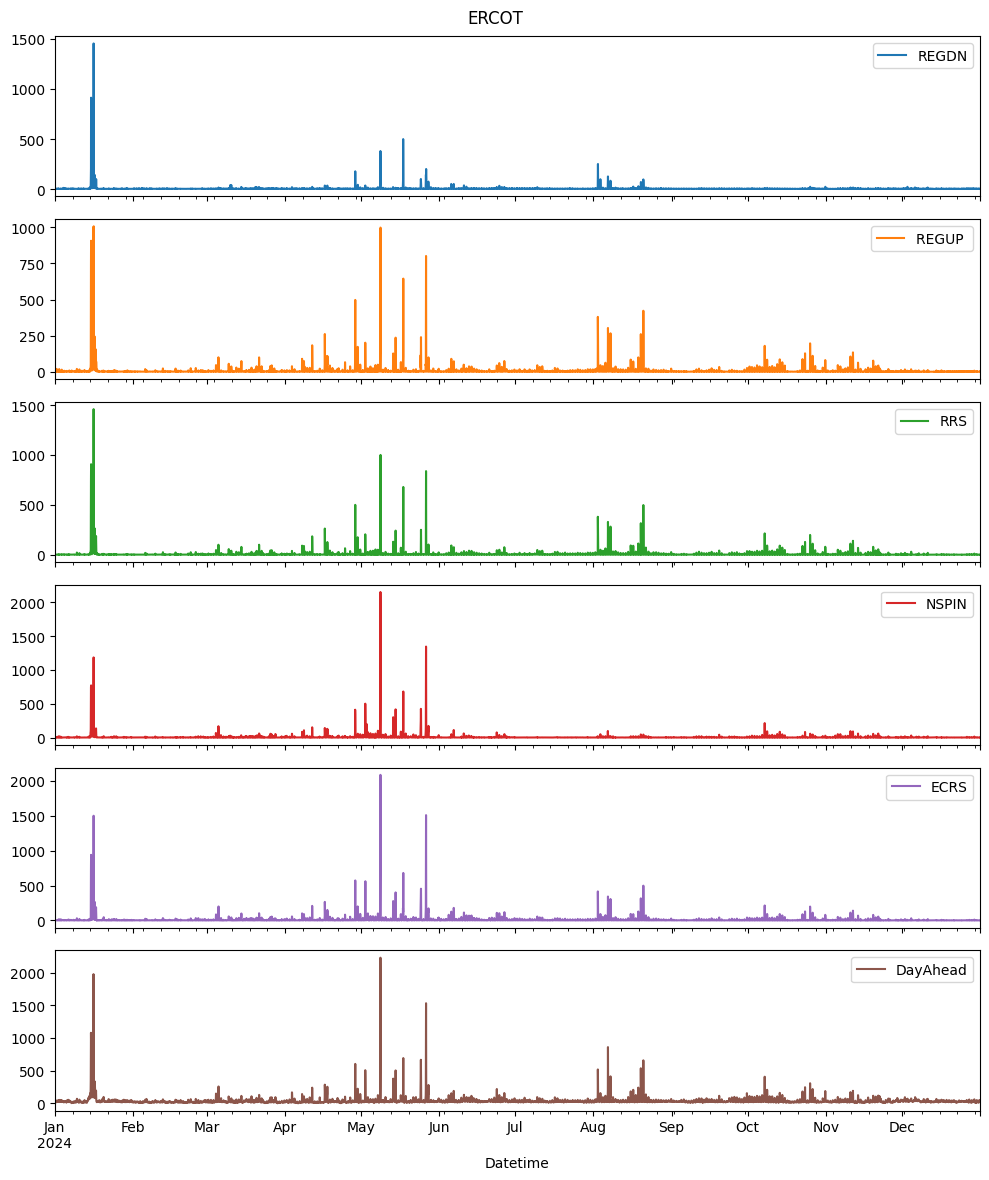

In [15]:
import warnings
warnings.filterwarnings("ignore")

# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(10, 2*6))
ERCOT.plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="ERCOT",
    ax=ax,
)
fig.tight_layout();

In [16]:
DA = ERCOT[['DayAhead']]

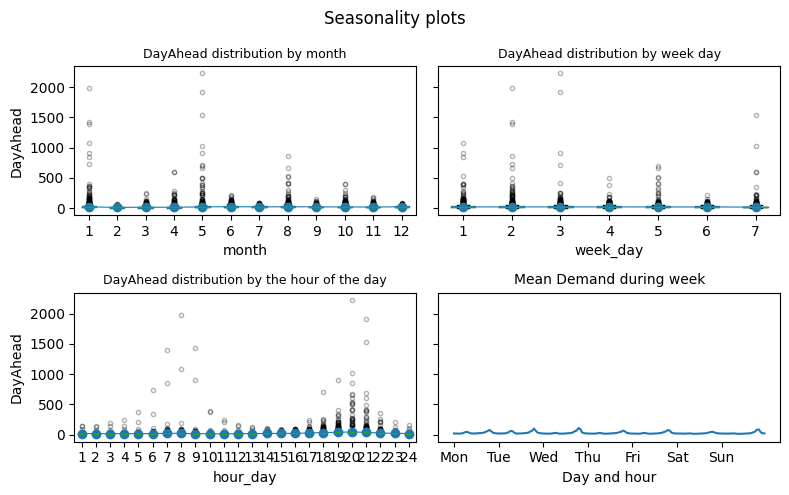

In [17]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demand distribution by month
DA['month'] = DA.index.month
DA.boxplot(column='DayAhead', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
DA.groupby('month')['DayAhead'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('DayAhead')
axs[0].set_title('DayAhead distribution by month', fontsize=9)

# Demand distribution by week day
DA['week_day'] = DA.index.day_of_week + 1
DA.boxplot(column='DayAhead', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
DA.groupby('week_day')['DayAhead'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('DayAhead')
axs[1].set_title('DayAhead distribution by week day', fontsize=9)

# Demand distribution by the hour of the day
DA['hour_day'] = DA.index.hour + 1
DA.boxplot(column='DayAhead', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
DA.groupby('hour_day')['DayAhead'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('DayAhead')
axs[2].set_title('DayAhead distribution by the hour of the day', fontsize=9)

# Demand distribution by week day and hour of the day
mean_day_hour = DA.groupby(["week_day", "hour_day"])["DayAhead"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean Demand during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of Demand"
)
axs[3].title.set_size(10)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

In [21]:
# Split data into train-val-test
# ==============================================================================
end_train = '2024-09-30 23:00:00'
end_validation = '2024-11-30 23:00:00'
DA_train = DA.loc[: end_train, :].copy()
DA_val   = DA.loc[end_train:end_validation, :].copy()
DA_test  = DA.loc[end_validation:, :].copy()

print(f"Train dates      : {DA_train.index.min()} --- {DA_train.index.max()}  (n={len(DA_train)})")
print(f"Validation dates : {DA_val.index.min()} --- {DA_val.index.max()}  (n={len(DA_val)})")
print(f"Test dates       : {DA_test.index.min()} --- {DA_test.index.max()}  (n={len(DA_test)})")

Train dates      : 2024-01-01 00:00:00 --- 2024-09-30 23:00:00  (n=6576)
Validation dates : 2024-09-30 23:00:00 --- 2024-11-30 23:00:00  (n=1465)
Test dates       : 2024-11-30 23:00:00 --- 2024-12-31 23:00:00  (n=745)


#### Baseline Model

In [34]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=DA.loc[:end_validation, 'DayAhead'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2024-01-01 00:00:00'), Timestamp('2024-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2025-02-19 18:52:19 
Last fit date: 2025-02-19 18:52:19 
Skforecast version: 0.14.0 
Python version: 3.12.8 
Forecaster id: None 

In [36]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(DA.loc[:end_validation]),
        refit              = False
)
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = DA['DayAhead'],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                       )
metric

  0%|          | 0/31 [00:00<?, ?it/s]

,mean_absolute_error
0,8.317562


#### Direct Multi-step forecasting model

In [65]:
# Create forecaster - Direct method
# ==============================================================================
window_features = RollingFeatures(stats=["mean", "std", "mean", "std"], window_sizes=[3,3,24,24])
forecaster = ForecasterDirect(
                 regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                 lags            = 24,
                 steps = 24,
                 window_features = window_features,
                 transformer_y=StandardScaler(),
                 transformer_exog=StandardScaler(),
             )

forecaster_rf = ForecasterDirect(
                 regressor       = RandomForestRegressor(),
                 lags            = 24,
                 steps = 24,
                 window_features = window_features,
                 transformer_y=StandardScaler(),
                 transformer_exog=StandardScaler(),
             )

In [66]:
# Train forecaster
# ==============================================================================


forecaster.fit(y=DA.loc[:end_validation, 'DayAhead'])
forecaster

================ 
ForecasterDirect 
================ 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_3', 'roll_std_3', 'roll_mean_24', 'roll_std_24'] 
Window size: 24 
Maximum steps to predict: 24 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-01-01 00:00:00'), Timestamp('2024-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-02-19 20:11:47 
Last fit date: 2025-02-19 20:11:50 
Skforecast version: 0.14.0 
Python version: 3.12.8 
Forecaster id: None

In [67]:
# Backtesting
# ==============================================================================

cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(DA.loc[:end_validation]),
        refit              = False
)

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = DA['DayAhead'],
                          cv            = cv,
                          metric        = ['mean_absolute_error'],
                          n_jobs        = 'auto',
                          verbose       = True, # Set to False to avoid printing
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 8040
Number of observations used for backtesting: 744
    Number of folds: 31
    Number skipped folds: 0 
    Number of steps per fold: 24
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2024-01-01 00:00:00 -- 2024-11-30 23:00:00  (n=8040)
    Validation: 2024-12-01 00:00:00 -- 2024-12-01 23:00:00  (n=24)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-12-02 00:00:00 -- 2024-12-02 23:00:00  (n=24)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-12-03 00:00:00 -- 2024-12-03 23:00:00  (n=24)
Fold: 3
    Training:   No training in this fold
    Validation: 2024-12-04 00:00:00 -- 2024-12-04 23:00:00  (n=24)
Fold: 4
    Training:   No training in this fold
    Validation: 2024-12-05 00:00:00 -- 2024-12-05 23:00:00  (n=24)
Fold: 5
    Training:   No training in this fold
    Validatio

  0%|          | 0/31 [00:00<?, ?it/s]

In [68]:
metric

,mean_absolute_error
0,8.678401


<Axes: xlabel='Datetime'>

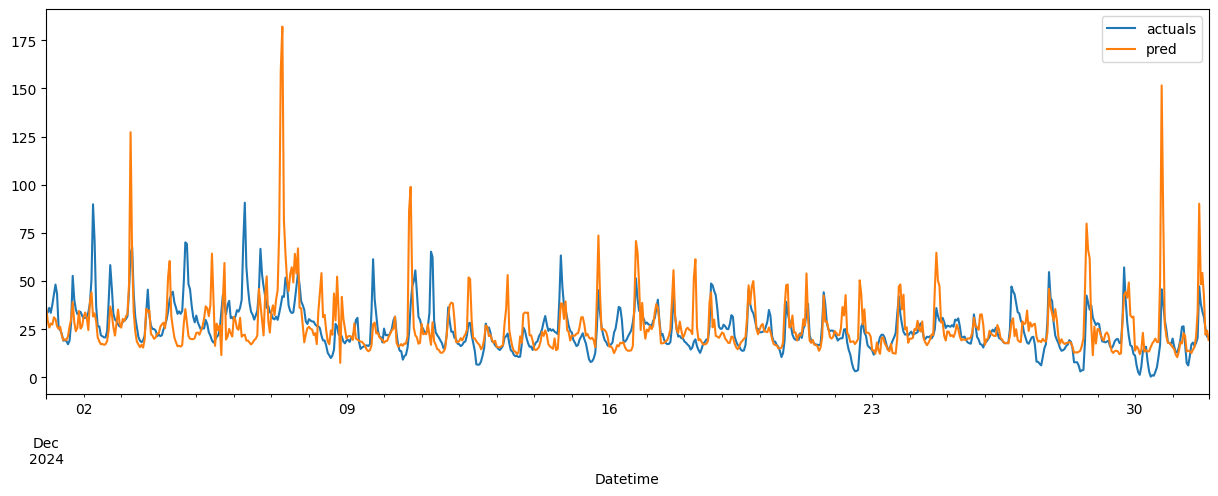

In [69]:
# Plot the forecast vs the actual
fig, ax = plt.subplots(figsize=(15, 5))
ERCOT.loc['2024-12-01 00:00:00':'2024-12-31 23:00:00', 'DayAhead'].plot(
        legend=True,
        label="actuals",
        ax=ax,
    )
predictions.iloc[:,].plot(
        legend=True,
        label="forecast_direct",
        ax=ax,
    )

In [70]:
# Hyperparameters search - enhance model accuracy
# ==============================================================================
#forecaster = ForecasterDirect(
#                 regressor       = LGBMRegressor(random_state=15926, verbose=-1),
#                 lags            = 24, # This value will be replaced in the grid search
#                 window_features = window_features,
#                 steps = 24
#             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 4, 5, 6, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 2000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds training and validation
cv_search = TimeSeriesFold(
                steps              = 24,
                initial_train_size = len(DA[:end_train]),
                refit              = False,
            )

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster    = forecaster,
                                   y             = DA.loc[:end_validation, 'DayAhead'],
                                   cv            = cv_search,
                                   metric        = 'mean_absolute_error',
                                   search_space  = search_space,
                                   n_trials      = 10, # Increase for more exhaustive search
                                   random_state  = 123,
                                   return_best   = True,
                                   n_jobs        = 'auto',
                                   verbose       = False,
                                   show_progress = True
                               )

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.05513142057308684, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
  Backtesting metric: 13.135691407813104


In [71]:
# Search results
# ==============================================================================
best_params = results_search.at[0, 'params']
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags = results_search.at[0, 'lags']
results_search.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 8, 'learnin...",13.135691,600.0,8.0,0.055131,0.4,0.4
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1400, 'max_depth': 6, 'learni...",14.769836,1400.0,6.0,0.202138,0.3,0.8
2,"[1, 2, 3, 4, 5, 6, 23, 24, 25, 47, 48, 49]","{'n_estimators': 1400, 'max_depth': 9, 'learni...",15.385139,1400.0,9.0,0.050766,0.8,0.2


In [72]:
# Best model
# ==============================================================================
forecaster

================ 
ForecasterDirect 
================ 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_3', 'roll_std_3', 'roll_mean_24', 'roll_std_24'] 
Window size: 24 
Maximum steps to predict: 24 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2024-01-01 00:00:00'), Timestamp('2024-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.05513142057308684,
    'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 600, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.4,
    'reg_lambda': 0.4, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-02-19 20:11:47 
Last fit date: 2025-02-19 20:19:31 
Skforecast version: 0.14.0 
Python version: 3.12.8 
Forecaster id: None

In [74]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = DA['DayAhead'],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False, # Change to True to see detailed information
                          show_progress = True
                      )

display(metric)
predictions.head()

  0%|          | 0/31 [00:00<?, ?it/s]

,mean_absolute_error
0,8.748225


,pred
2024-12-01 00:00:00,37.040951
2024-12-01 01:00:00,30.766027
2024-12-01 02:00:00,30.714896
2024-12-01 03:00:00,31.866900
2024-12-01 04:00:00,28.069062


In [83]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables='index',
    features_to_extract=features_to_extract,
    drop_original=True,
)
calendar_features = calendar_transformer.fit_transform(DA)[features_to_extract]

# Sunlight features
# ==============================================================================
#location = LocationInfo(
#    latitude=31.0609533,
#    longitude=-105.3610545,
#    timezone='America/Chicago'
#)
#sunrise_hour = [
#    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise']
#    for date in DA.index
#]
#sunset_hour = [
#    sun(location.observer, date=date, tzinfo=location.timezone)['sunset']
#    for date in DA.index
#]
#sunrise_hour = pd.Series(sunrise_hour, index=DA.index).dt.round("h").dt.hour
#sunset_hour = pd.Series(sunset_hour, index=DA.index).dt.round("h").dt.hour
#sun_light_features = pd.DataFrame({
#                        'sunrise_hour': sunrise_hour,
#                        'sunset_hour': sunset_hour
#                     })
#sun_light_features['daylight_hours'] = (
#    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
#)
#sun_light_features["is_daylight"] = np.where(
#    (DA.index.hour >= sun_light_features["sunrise_hour"])
#    & (DA.index.hour < sun_light_features["sunset_hour"]),
#    1,
#    0,
#)


# Merge all exogenous variables
# ==============================================================================
#assert all(calendar_features.index == sun_light_features.index)
#assert all(calendar_features.index == temp_features.index)
#assert all(calendar_features.index == holiday_features.index)
exogenous_features = pd.concat([
                         calendar_features,
#                         sun_light_features,
 #                        temp_features,
 #                        holiday_features
                     ], axis=1)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
exogenous_features = exogenous_features.iloc[7 * 24:, :]
exogenous_features = exogenous_features.iloc[:-24, :]
exogenous_features.head(3)

,month,week,day_of_week,hour
Datetime,,,,
2024-01-15 00:00:00,1,3,0,0
2024-01-15 01:00:00,1,3,0,1
2024-01-15 02:00:00,1,3,0,2


In [84]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
#    "sunrise_hour",
#    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 6,
    "hour": 23,
#    "sunrise_hour": 23,
#    "sunset_hour": 23,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

exogenous_features = cyclical_encoder.fit_transform(exogenous_features)
exogenous_features.head(3)

,month,week,day_of_week,hour,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
Datetime,,,,,,,,,,,,
2024-01-15 00:00:00,1,3,0,0,0.5,0.866025,0.354605,0.935016,0.0,1.0,0.000000,1.000000
2024-01-15 01:00:00,1,3,0,1,0.5,0.866025,0.354605,0.935016,0.0,1.0,0.269797,0.962917
2024-01-15 02:00:00,1,3,0,2,0.5,0.866025,0.354605,0.935016,0.0,1.0,0.519584,0.854419


In [86]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin', 
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
#    'sunrise_hour_sin',
#    'sunrise_hour_cos',
#    'sunset_hour_sin',
#    'sunset_hour_cos',
#    'daylight_hours',
#    'is_daylight',
]
poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
assert all(poly_features.index == exogenous_features.index)
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
exogenous_features.head(3)

,month,week,day_of_week,hour,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,...,poly_week_cos__day_of_week_sin,poly_week_cos__day_of_week_cos,poly_week_cos__hour_sin,poly_week_cos__hour_cos,poly_day_of_week_sin__day_of_week_cos,poly_day_of_week_sin__hour_sin,poly_day_of_week_sin__hour_cos,poly_day_of_week_cos__hour_sin,poly_day_of_week_cos__hour_cos,poly_hour_sin__hour_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-15 00:00:00,1,3,0,0,0.5,0.866025,0.354605,0.935016,0.0,1.0,...,0.0,0.935016,0.000000,0.935016,0.0,0.0,0.0,0.000000,1.000000,0.000000
2024-01-15 01:00:00,1,3,0,1,0.5,0.866025,0.354605,0.935016,0.0,1.0,...,0.0,0.935016,0.252264,0.900343,0.0,0.0,0.0,0.269797,0.962917,0.259792
2024-01-15 02:00:00,1,3,0,2,0.5,0.866025,0.354605,0.935016,0.0,1.0,...,0.0,0.935016,0.485819,0.798896,0.0,0.0,0.0,0.519584,0.854419,0.443943


In [87]:
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())

In [88]:
# Merge target and exogenous variables in the same DataFrame
# ==============================================================================
DA = DA[['DayAhead']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='inner' # Use only dates for which we have all the variables
       )
DA = DA.astype('float32')

# Split data into train-val-test
DA_train = DA.loc[: end_train, :].copy()
DA_val   = DA.loc[end_train:end_validation, :].copy()
DA_test  = DA.loc[end_validation:, :].copy()

In [98]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor       = LGBMRegressor(**best_params),
                 lags            = best_lags,
                 window_features = window_features,
                 steps = 24
             )

In [99]:
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = DA['DayAhead'],
                          exog          = DA[exog_features],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )
display(metric)
predictions.head()

  0%|          | 0/15 [00:00<?, ?it/s]

,mean_absolute_error
0,6.929649


,pred
2024-12-15 00:00:00,22.694171
2024-12-15 01:00:00,23.285699
2024-12-15 02:00:00,23.007411
2024-12-15 03:00:00,22.489293
2024-12-15 04:00:00,31.030221


- Adding exogenous features such as month, day, day of week, and hour have lowered the error metric and improved the accuracy of the model. Some features such as 'sunlight' and 'daylight' have previously worsened the performance of the model and therefore have been removed.  

In [100]:
predictions

,pred
2024-12-15 00:00:00,22.694171
2024-12-15 01:00:00,23.285699
2024-12-15 02:00:00,23.007411
2024-12-15 03:00:00,22.489293
2024-12-15 04:00:00,31.030221
...,...
2024-12-29 19:00:00,69.591392
2024-12-29 20:00:00,52.856031
2024-12-29 21:00:00,29.997268
2024-12-29 22:00:00,22.695917


<Axes: xlabel='Datetime'>

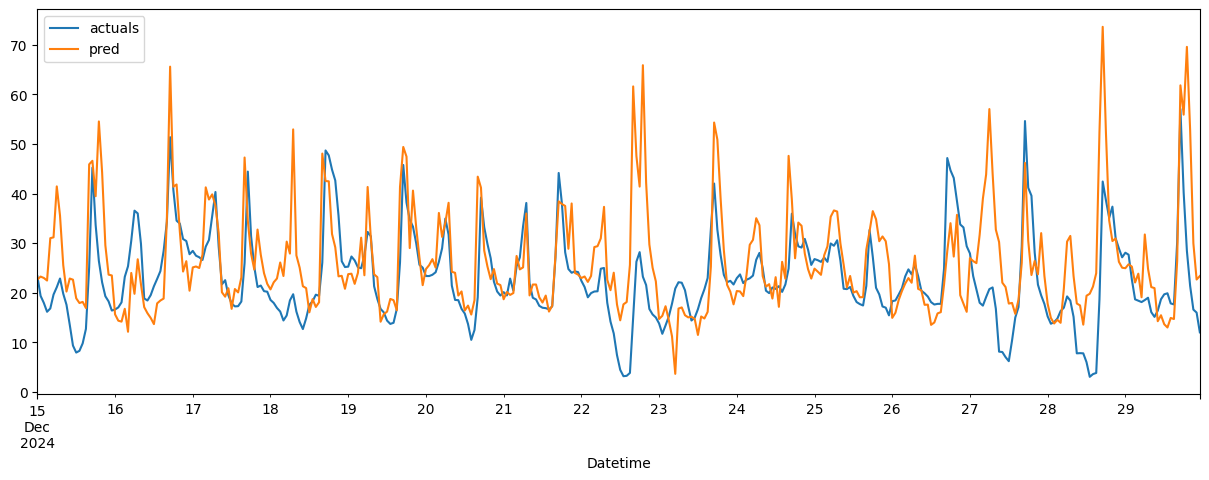

In [102]:
# Plot the forecast vs the actual
fig, ax = plt.subplots(figsize=(15, 5))
ERCOT.loc['2024-12-15 00:00:00':'2024-12-29 23:00:00', 'DayAhead'].plot(
        legend=True,
        label="actuals",
        ax=ax,
    )
predictions.iloc[:,].plot(
        legend=True,
        label="forecast_direct",
        ax=ax,
    )

#### Model Interpretation & Feature Importance

In [104]:
forecaster.fit(
    y    = DA.loc[:end_validation, 'DayAhead'],
    exog = DA.loc[:end_validation, exog_select]
)

In [106]:
# Model-specific feature importances - step 1
# ==============================================================================
feature_importances = forecaster.get_feature_importances(step = 1)
feature_importances.head(10)

,feature,importance
0,lag_1,1295
25,roll_std_3,865
24,roll_mean_3,843
1,lag_2,664
27,roll_std_24,624
2,lag_3,446
23,lag_24,437
22,lag_23,413
32,poly_month_cos__hour_sin,308
26,roll_mean_24,267


In [109]:
# Model-specific feature importances - step 12
# ==============================================================================
feature_importances = forecaster.get_feature_importances(step = 12)
feature_importances.head(10)

,feature,importance
12,lag_13,2074
13,lag_14,969
27,roll_std_24,768
35,poly_week_sin__hour_sin,669
11,lag_12,666
36,poly_week_cos__day_of_week_sin,617
34,poly_week_sin__day_of_week_cos,530
4,lag_5,521
37,poly_week_cos__hour_sin,505
23,lag_24,470


In [107]:
# Model-specific feature importances - step 24
# ==============================================================================
feature_importances = forecaster.get_feature_importances(step = 24)
feature_importances.head(10)

,feature,importance
23,lag_24,1367
25,roll_std_3,1225
0,lag_1,1037
27,roll_std_24,840
35,poly_week_sin__hour_sin,736
36,poly_week_cos__day_of_week_sin,681
1,lag_2,680
34,poly_week_sin__day_of_week_cos,571
37,poly_week_cos__hour_sin,497
26,roll_mean_24,479
